# IS597MLC: Final Project Report
                                                  
## NetID: hva3
## Student Name: Harshal Abhyankar

## Exploring LSTM Models for Twitter Bot Detection

## Instructions: Execute each cell in order and all models should work correctly as all required modules and data are already included in this repository. By running the cell below, GloVe pretrained embeddings will be downloaded and unzipped (This may take a few minutes). These BiLSTM models were developed on a ml.t3.xlarge instance.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [1]:
!pip install tensorflow keras pandas numpy

In [2]:
# Importing necessary libraries and modules
from preprocess_data import *
from evaluate_model import *
from models import *
from sklearn.model_selection import train_test_split
import nltk

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

2024-12-11 06:53:17.861465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733899997.887788   21106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733899997.895120   21106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 06:53:17.917660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwo

True

## Load and Sample Data

In [3]:
# Load the dataset
data_path = './Twitter_Data.csv'
df_data = pd.read_csv(data_path)

In [4]:
# Display basic information about the dataset
print(f"------------------------------------------------\nDataset shape: {df_data.shape}\n")
print(f"Columns: {df_data.columns}\n")
print(df_data.head())

# Handle missing values
# Fill missing hashtags with empty strings
df_data['Tweet_text'].fillna('')
print(f"\n------------------------------------------------\nShape after filling empty tweets: {df_data.shape}")# Drop rows with significant missing values in other critical columns
df_data.dropna(subset=['Tweet_text', 'Twitter_Account', 'Label'], inplace=True)
print(f"\n------------------------------------------------\nShape after dropping missing data rows: {df_data.shape}")
# Remove duplicates
df_data.drop_duplicates(inplace=True)
print(f"\n ------------------------------------------------\nShape after dropping duplicates: {df_data.shape}")

# Since the dataset is too large and we have limited compute, we will randomly sample 50,000 rows
# from the dataset for this project
# Sample 50,000 rows with stratification
df, _ = train_test_split(df_data, train_size=50000, stratify=df_data["Label"], random_state=42)

# Reset the index to keep it consistent
df = df.reset_index(drop=True)

# Display the shape of the sampled dataset
print(f"\n------------------------------------------------\nSampled dataset shape: {df.shape}\n")
print(f"\n------------------------------------------------\nFirst five rows:\n{df.head()}\n\n")
print(f"------------------------------------------------\nLabel value counts: \n{df['Label'].value_counts()}")

------------------------------------------------
Dataset shape: (292626, 7)

Columns: Index(['Twitter_User_Name', 'Twitter_Account', 'Twitter_User_Description',
       'Tweet_id', 'Tweet_created_at', 'Tweet_text', 'Label'],
      dtype='object')

  Twitter_User_Name Twitter_Account  \
0        Museum Bot       MuseumBot   
1      Horse ebooks    Horse_ebooks   
2         Garry12gg       garry12gg   
3        Sadiq Khan       SadiqKhan   
4  Ace Attorney Bot  aceattorneybot   

                            Twitter_User_Description             Tweet_id  \
0  I am a bot that tweets a random high-res Open ...   802757608646082560   
1                                       Horse ebooks   360700292859310080   
2   I like to learn new things and play video games.   976198950830133259   
3                         Mayor of London. #TeamKhan   969218828696719361   
4  No clues here. (unofficial and not even remote...  1066842747636670465   

      Tweet_created_at                                 

## Preprocessing Data

In [5]:
# Preprocess the dataset (does take some time to load glove embeddings)
# Here we are keeping the original Tweet Text column as well since we need it for feature engineering later
X, y, embedding_matrix = preprocess_twitter_data(df, glove_path="glove.6B.100d.txt", max_length=100)

# Inspect the resulting DataFrame
print("------------------------------------------------\nPreprocessed Feature DataFrame (X):")
print(X.head())

# Inspect padded sequences for the first row
print("\n------------------------------------------------\nPadded Sequences for the first row:", X["Padded_Sequences"].iloc[0])

# Inspect target labels
print("\n------------------------------------------------\nTarget labels:")
print(y[:5])

Loaded 400000 GloVe word vectors.
------------------------------------------------
Preprocessed Feature DataFrame (X):
      Twitter_User_Name Twitter_Account  \
0      hi i have advice   nice_tips_bot   
1           Sarah Nagem     sarah_nagem   
2            Imran Khan    ImranKhanPTI   
3  here's your reminder     tinycarebot   
4          Horse ebooks    Horse_ebooks   

                            Twitter_User_Description  \
0  hello, i am a robot that tweets little life ti...   
1  Assistant metro editor at The News & Observer....   
2                         Prime Minister of Pakistan   
3  please take a break! for a personal reminder, ...   
4                                       Horse ebooks   

                                          Tweet_text  \
0  b"@candidartichoke @wit_haze and so, don't say...   
1  b"RT @newsobserver: An attorney for eight Samp...   
2  b'#PTISMT @ptiofficial brings you #IKLiveWithS...   
3  b'\xf0\x9f\x92\x9c: please take a quick break ...   
4  b'

## Feature Engineering 

In [6]:
import pandas as pd
import numpy as np
import re

# Feature 1: Check for keywords like "bot", "automation", etc.
keywords = ['bot', 'automation', 'auto', 'robot']
regex = '|'.join(keywords)

def contains_keywords(row):
    combined_text = f"{row['Twitter_User_Name']} {row['Twitter_User_Description']}"
    return int(bool(re.search(regex, combined_text, flags=re.IGNORECASE)))

X['Contains_Bot_Keyword'] = X.apply(contains_keywords, axis=1)

# Feature 2: Count hashtags (#) and mentions (@) in metadata
def count_hashtags_mentions(row):
    combined_text = f"{row['Twitter_User_Name']} {row['Twitter_User_Description']}"
    return combined_text.count('#') + combined_text.count('@')

X['Hashtags_Mentions_Count'] = X.apply(count_hashtags_mentions, axis=1)

# Display updated DataFrame
print(f"------------------------------------------------\nData after adding 2 new features:\n\n{X.head()}\n")

------------------------------------------------
Data after adding 2 new features:

      Twitter_User_Name Twitter_Account  \
0      hi i have advice   nice_tips_bot   
1           Sarah Nagem     sarah_nagem   
2            Imran Khan    ImranKhanPTI   
3  here's your reminder     tinycarebot   
4          Horse ebooks    Horse_ebooks   

                            Twitter_User_Description  \
0  hello, i am a robot that tweets little life ti...   
1  Assistant metro editor at The News & Observer....   
2                         Prime Minister of Pakistan   
3  please take a break! for a personal reminder, ...   
4                                       Horse ebooks   

                                          Tweet_text  \
0  b"@candidartichoke @wit_haze and so, don't say...   
1  b"RT @newsobserver: An attorney for eight Samp...   
2  b'#PTISMT @ptiofficial brings you #IKLiveWithS...   
3  b'\xf0\x9f\x92\x9c: please take a quick break ...   
4  b'LINK WHEEL TRAFFIC 4PRO http://t.co

## Split data in Train and Test

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Extract padded sequences for text input (only for BiLSTM without numerical features)
X_text_train = np.array(X_train["Padded_Sequences"].to_list())
X_text_test = np.array(X_test["Padded_Sequences"].to_list())

# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (40000, 8)
X_test shape: (10000, 8)
y_train shape: (40000,)
y_test shape: (10000,)


## Training and Evaluating BiLSTM model

In [8]:
# Create the model
model_bilstm = create_bidirectional_lstm_model(embedding_matrix=embedding_matrix)

# Display model summary
model_bilstm.summary()

# Train the model (Should take about 5 minutes)
history_bilstm = model_bilstm.fit(
    X_text_train, 
    y_train, 
    epochs=5,  
    batch_size=64, 
    validation_data=(X_text_test, y_test), 
    verbose=1
)

2024-12-11 05:49:56.972355: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,899,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,899,300 (22.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,899,300 (22.50 MB)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.6235 - loss: 0.6414 - val_accuracy: 0.7296 - val_loss: 0.5285
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.7171 - loss: 0.5456 - val_accuracy: 0.7694 - val_loss: 0.4736
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.7486 - loss: 0.5085 - val_accuracy: 0.7683 - val_loss: 0.4557
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 82ms/step - accuracy: 0.7646 - loss: 0.4820 - val_accuracy: 0.7841 - val_loss: 0.4396
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.7716 - loss: 0.4682 - val_accuracy: 0.7969 - val_loss: 0.4236


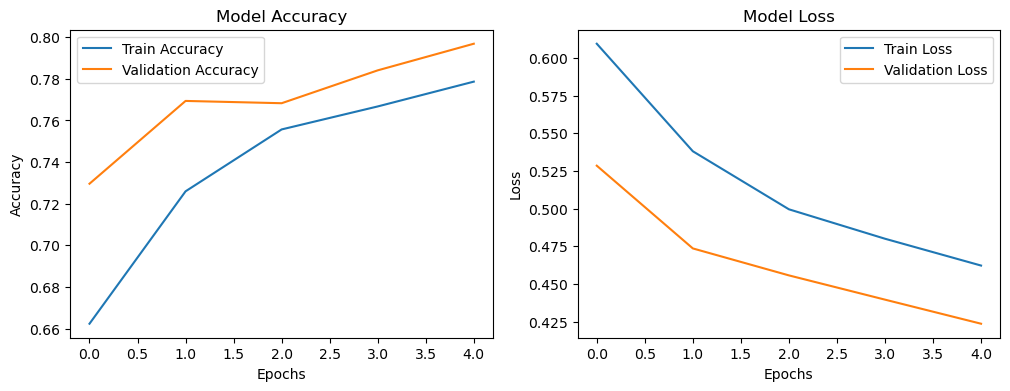

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      4962
           1       0.75      0.89      0.82      5038

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.79     10000
weighted avg       0.81      0.80      0.80     10000



In [9]:
evaluate_model_performance(history_bilstm, model_bilstm, X_text_test, y_test)

## Training and Evaluating Hybrid BiLSTM model

In [9]:
# Seperate numerical features for input into the hybrid model
numerical_columns = ["Contains_Bot_Keyword", "Hashtags_Mentions_Count"]  # Relevant numerical features
X_num_train = X_train[numerical_columns].to_numpy()  # Extract relevant numerical features
X_num_test = X_test[numerical_columns].to_numpy()

In [11]:
# Create the hybrid model
model_hybrid_bilstm = create_hybrid_bilstm_model(
    embedding_matrix=embedding_matrix,
    input_length=X_text_train.shape[1],  # Length of padded sequences
    numerical_input_dim=X_num_train.shape[1]  # Number of numerical features
)

# Print model summary
model_hybrid_bilstm.summary()

# Train the model
history_hybrid_bilstm = model_hybrid_bilstm.fit(
    [X_text_train, X_num_train],  # Provide both text and numerical inputs
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=([X_text_test, X_num_test], y_test),
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Text_Input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 100)  │  5,899,300 │ Text_Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Numerical_Input     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     84,480 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │         24 │ Numerical_Input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 136)       │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      4,384 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,988,221 (22.84 MB)

 Trainable params: 88,921 (347.35 KB)

 Non-trainable params: 5,899,300 (22.50 MB)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.7198 - loss: 0.5242 - val_accuracy: 0.9090 - val_loss: 0.2341
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.9017 - loss: 0.2592 - val_accuracy: 0.9177 - val_loss: 0.1977
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9126 - loss: 0.2212 - val_accuracy: 0.9253 - val_loss: 0.1818
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.9131 - loss: 0.2089 - val_accuracy: 0.9295 - val_loss: 0.1699
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9203 - loss: 0.1975 - val_accuracy: 0.9318 - val_loss: 0.1604


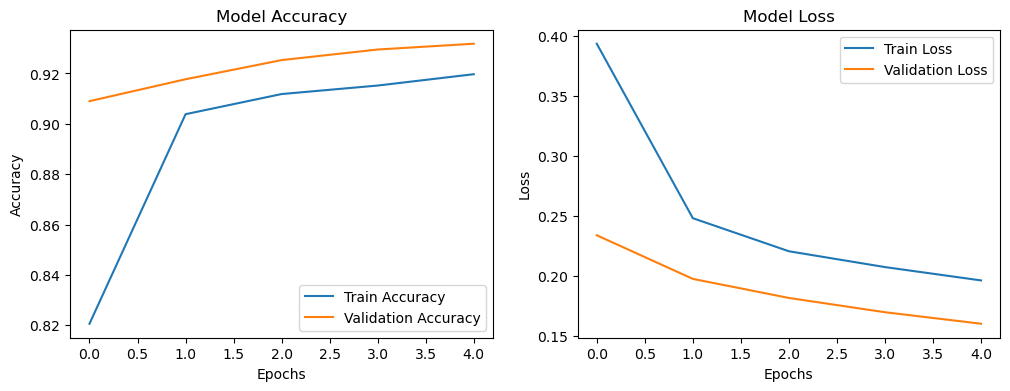

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4962
           1       0.91      0.96      0.93      5038

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [12]:
evaluate_model_performance(history_hybrid_bilstm, model_hybrid_bilstm, [X_text_test, X_num_test], y_test)

## Additional Hyperparameter Tuning

In [10]:
## This part takes a lot of time but in summary it is found that ideal learning rate is __ and batch size is for hybrid model.

# By looking at accuracy for the first few epochs, the learning slows down greatly after 5th epoch so
# hyperparameter for number of epochs is set to 5

# Define hyperparameters to tune
batch_sizes = [16, 32, 64]  # Batch sizes to test

# Initialize results storage
results = []
lr=1e-4

# Loop through combinations of hyperparameters
for batch_size in batch_sizes:
    print(f"Training model with learning_rate={lr} and batch_size={batch_size}...")

    # Create model
    model = create_hybrid_bilstm_model_with_lr(
        embedding_matrix=embedding_matrix,
        input_length=X_text_train.shape[1],
        numerical_input_dim=X_num_train.shape[1],
        learning_rate=lr
    )

    # Train model
    history = model.fit(
        [X_text_train, X_num_train], y_train,
        validation_data=([X_text_test, X_num_test], y_test),
        epochs=5,
        batch_size=batch_size,
        verbose=1
    )

    # Evaluate model
    loss, accuracy = model.evaluate([X_text_test, X_num_test], y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Save results
    results.append({"learning_rate": lr, "batch_size": batch_size, "loss": loss, "accuracy": accuracy})

# Display results
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}, "
          f"Loss: {result['loss']:.4f}, Accuracy: {result['accuracy']:.4f}")

    
## By evaluating the time taken vs final accuracy for each batch size, 32 is the ideal batch size for 
## training this model over a large dataset.

Training model with learning_rate=0.0001 and batch_size=16...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-11 06:53:49.310247: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 121s 47ms/step - accuracy: 0.7045 - loss: 0.5866 - val_accuracy: 0.8774 - val_loss: 0.3268
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 118s 47ms/step - accuracy: 0.8767 - loss: 0.3341 - val_accuracy: 0.8977 - val_loss: 0.2617
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 122s 49ms/step - accuracy: 0.8919 - loss: 0.2953 - val_accuracy: 0.9028 - val_loss: 0.2404
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 119s 48ms/step - accuracy: 0.8976 - loss: 0.2738 - val_accuracy: 0.9048 - val_loss: 0.2317
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 122s 49ms/step - accuracy: 0.9006 - loss: 0.2584 - val_accuracy: 0.9111 - val_loss: 0.2206
Test Loss: 0.2206, Test Accuracy: 0.9111
Training model with learning_rate=0.0001 and batch_size=32...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 55ms/step - accuracy: 0.6101 - loss: 0.6515 - val_accuracy: 0.8228 - val_loss: 0.4745
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.8173 - loss: 0.4562 - val_accuracy: 0

In [11]:
learning_rates = [1e-4, 1e-3, 1e-2]  # Learning rates to test
# Initialize results storage
results = []
batch_size=32

# Loop through combinations of hyperparameters
for lr in learning_rates:
    print(f"Training model with learning_rate={lr} and batch_size={batch_size}...")

    # Create model
    model = create_hybrid_bilstm_model_with_lr(
        embedding_matrix=embedding_matrix,
        input_length=X_text_train.shape[1],
        numerical_input_dim=X_num_train.shape[1],
        learning_rate=lr
    )

    # Train model
    history = model.fit(
        [X_text_train, X_num_train], y_train,
        validation_data=([X_text_test, X_num_test], y_test),
        epochs=5,
        batch_size=batch_size,
        verbose=1
    )

    # Evaluate model
    loss, accuracy = model.evaluate([X_text_test, X_num_test], y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Save results
    results.append({"learning_rate": lr, "batch_size": batch_size, "loss": loss, "accuracy": accuracy})

# Display results
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}, "
          f"Loss: {result['loss']:.4f}, Accuracy: {result['accuracy']:.4f}")
    
## 

Training model with learning_rate=0.0001 and batch_size=32...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 56ms/step - accuracy: 0.6323 - loss: 0.6425 - val_accuracy: 0.8055 - val_loss: 0.4560
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.8210 - loss: 0.4416 - val_accuracy: 0.8917 - val_loss: 0.3122
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 52ms/step - accuracy: 0.8759 - loss: 0.3381 - val_accuracy: 0.8977 - val_loss: 0.2691
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 52ms/step - accuracy: 0.8870 - loss: 0.3068 - val_accuracy: 0.8987 - val_loss: 0.2581
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.8929 - loss: 0.2895 - val_accuracy: 0.9036 - val_loss: 0.2416
Test Loss: 0.2416, Test Accuracy: 0.9036
Training model with learning_rate=0.001 and batch_size=32...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 51ms/step - accuracy: 0.7654 - loss: 0.4765 - val_accuracy: 0.9157 - val_loss: 0.2183
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/

Epoch 1/5


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step - accuracy: 0.7929 - loss: 0.4401 - val_accuracy: 0.9074 - val_loss: 0.2172
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.9071 - loss: 0.2330 - val_accuracy: 0.9212 - val_loss: 0.1864
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.9136 - loss: 0.2138 - val_accuracy: 0.9253 - val_loss: 0.1695
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 52ms/step - accuracy: 0.9184 - loss: 0.1973 - val_accuracy: 0.9310 - val_loss: 0.1603
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.9214 - loss: 0.1906 - val_accuracy: 0.9344 - val_loss: 0.1523


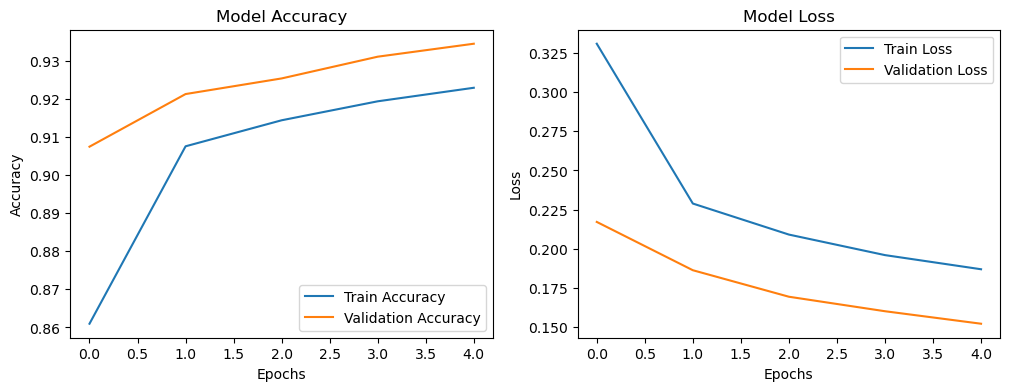

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      4962
           1       0.91      0.96      0.94      5038

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000



In [13]:
# Create fine tuned hybrid model
model = create_hybrid_bilstm_model_with_lr(
        embedding_matrix=embedding_matrix,
        input_length=X_text_train.shape[1],
        numerical_input_dim=X_num_train.shape[1],
        learning_rate=0.001
    )

# Train model
history = model.fit(
        [X_text_train, X_num_train], y_train,
        validation_data=([X_text_test, X_num_test], y_test),
        epochs=5,
        batch_size=32,
        verbose=1
    )

evaluate_model_performance(history, model, [X_text_test, X_num_test], y_test)